In [1]:
pip install cartopy

Defaulting to user installation because normal site-packages is not writeable
^C
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/cplex20-pro/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/anaconda3/envs/cplex20-pro/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/envs/cplex20-pro/lib/python3.8/site-packages/pip/__main__.py", line 31, in <module>
    sys.exit(_main())
  File "/usr/local/anaconda3/envs/cplex20-pro/lib/python3.8/site-packages/pip/_internal/cli/main.py", line 70, in main
    return command.main(cmd_args)
  File "/usr/local/anaconda3/envs/cplex20-pro/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 98, in main
    return self._main(args)
  File "/usr/local/anaconda3/envs/cplex20-pro/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 214, in _main
    self.handle_pip_version_check(option

In [1]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import math


def showSolution(data,solution):
    
    # get some data
    minVisiDuration = data['minVisiDuration']
    AOIs = data['AOIs']
    accesses = data['Accesses']
    satPasses = data['Passes']
    
    # get the booking strategy
    bookings = solution['Bookings']
    bookings.sort(key=lambda item: satPasses[item["passId"]]['startDate'])    
    print("Bookings:")
    for booking in bookings:
        print(booking)
    
    # show the passes used
    ncols = 3
    nrows = math.ceil(len(solution['Bookings']) / ncols)
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(30,30))
    axs = axs.flatten()

    i = 0
    for booking in solution['Bookings']:
        passId = booking["passId"]
        satPass = satPasses[passId]
        ax = axs[i]
        ax.set_title("Pass #{} [{},{}]".format(passId,satPass['startDate'],satPass['endDate']))
        ax.set_extent([-15, 25, 35, 60])
        ax.stock_img()
        ax.add_feature(cf.COASTLINE, lw=1)
        ax.add_feature(cf.BORDERS)
        ax.plot([aoi['lon'] for aoi in AOIs], [aoi['lat'] for aoi in AOIs], 'kx')

        # show the reservations
        xpoints = []
        ypoints = []
        colors = []
        for accessId in satPass['accessIds']:
            access = accesses[accessId]
            aoi = AOIs[access['aoiId']]
            xpoints.append(aoi['lon'])
            ypoints.append(aoi['lat'])
            if (booking['bookingStart'] <= access['end'] - minVisiDuration) and (access['start'] + minVisiDuration <= booking['bookingEnd']):
                colors.append('r')
            else:
                colors.append('b')       
        ax.scatter(xpoints,ypoints,marker='o',c=colors)
        
        i = i + 1

    plt.show()

In [ ]:
def cout(data,solution) :
    
    fixedPassCost = data['fixedPassCost']
    passCostPerTimeUnit = data['passCostPerTimeUnit']
    booking = solution['Bookings']
    
    cout = 0
    
    for reservation in booking :
        cout += fixedPassCost
        cout += passCostPerTimeUnit*(reservation['bookingEnd'] - reservation['bookingStart'])
    
    return cout

def satisfaction(data , solution) :
    
    accesses = data['Accesses']
    obsRequests = data['ObservationRequests']
    nObsRequests = len(obsRequests)
    satPasses = data['Passes']    
    bookings = solution['Bookings']
    minVisiDuration = data['minVisiDuration']
    
    nObsRequestsCovered = 0
    
    passages = dict()
    for booking in bookings:
        passId = booking["passId"]
        passages[passId] = (booking['bookingStart'] , booking['bookingEnd'])

    for request in obsRequests :
        accessIds = request['accessIds'] # Liste des accessID
        request_satisfied = False
        
        for id in accessIds :
            pass_id = accesses[id]['passId'] # Le passage qui contient l'access
            
            if ( pass_id in passages ) and ( int(passages[pass_id][0]) <= accesses[id]['end'] - 30 ) and (int(passages[pass_id][1]) >= accesses[id]['start'] + 30) :
                request_satisfied = True
        
        if request_satisfied :
            nObsRequestsCovered += 1
            
    print(f"nObsRequestsCovered = {nObsRequestsCovered}")
    print(f"nObsRequests = {nObsRequests}")
    return nObsRequestsCovered/nObsRequests * 100
    

In [56]:
import random
import json
from docplex.mp.model import Model
import docplex as cplex
# import the data

dataFile = open('data/data2.json')  
data = json.load(dataFile)
accesses = data['Accesses']
obsRequests = data['ObservationRequests'];
nObsRequests = len(obsRequests)
satPasses = data['Passes'];

# a very basic solver

satisfied = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
nPasses = len(satPasses)
remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
for i in remainingSatPassesIds:
    # try to select the ith path
    satPass = satPasses[i]
    keepPass = False
    for accessId in satPass['accessIds']:
        access = accesses[accessId]
        for j in range(nObsRequests):
            obsRequest = obsRequests[j]
            if not satisfied[j] and accessId in obsRequest['accessIds']:
                satisfied[j] = True
                keepPass = True
                nObsRequestsToCover -= 1
                
    if keepPass:
        selectedPassIds.append(i)
            
    if nObsRequestsToCover == 0:
        break


print(selectedPassIds)
print(len(selectedPassIds))

bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()
solutionFile = open('mySolution.json')
solution = json.load(solutionFile)
c = cout(data , solution)
print(c)

[24, 8, 49, 67, 22, 51, 11, 36, 13, 38, 52, 66, 26, 3, 33, 37, 57, 62, 17, 1, 23, 68, 42, 6, 48, 4, 2, 63, 59, 34, 58, 41, 56, 9, 47, 50, 27, 10, 61, 15, 40, 53, 5, 25, 46, 28, 39, 16, 32, 12, 18, 14, 43, 20, 29, 21, 30]
57
19840.0


In [57]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)
c = cout(data , solution)
s = satisfaction(data,solution)
print(f"Le coût de la solution est {c}")
print(f"Le taux de satisfaction de la solution est {s}")
#showSolution(data,solution)

nObsRequestsCovered = 6867
nObsRequests = 6867
Le coût de la solution est 19840.0
Le taux de satisfaction de la solution est 100.0


In [58]:
import random
import json
from docplex.mp.model import Model
import docplex as cplex


# import the data

dataFile = open('data/data2.json')  
data = json.load(dataFile)
accesses = data['Accesses']
obsRequests = data['ObservationRequests'];
nObsRequests = len(obsRequests)
satPasses = data['Passes'];


# A simple DOCPLEX solution

satisfied = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
nPasses = len(satPasses)
remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']
passes = data['Passes']
obsRequests = data['ObservationRequests']
passes_dt = []
for i in range(nPasses) :
    passes_dt.append(passes[i]['end'] - passes[i]['start'])

    
model = Model(name='EO-requests')

x = model.binary_var_list(range(nObsRequests), name='satisfied_requests')
p = model.binary_var_list(range(nPasses), name='selected_passes')

for i in range(nObsRequests) :
  
    model.add_constraint( model.sum( p[accesses[accessId]['passId']] for accessId in obsRequests[i]['accessIds']) >= x[i])
    
    
for i in range(nObsRequests) :
    model.add_constraint(x[i] == 1)

model.minimize( model.sum( p[i] * ( fixedPassCost + passCostPerTimeUnit*passes_dt[i]) for i in range(nPasses) ))

# Résolution du problème
solution = model.solve(log_output=True)

# Affichage de la solution
for i in range(nPasses) :
    if p[i].solution_value == 1  :
        selectedPassIds.append(i)

if solution is None:
    print("NO solution")
else: 
    print("Le cout est de " , model.objective_value)
    print("Les passes séléctionnés sont :" , selectedPassIds)



# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": satPass['start'], "bookingEnd": satPass['end']})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()


Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
Found incumbent of value 22621.000000 after 0.00 sec. (0.51 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 13734 rows and 6936 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (7.83 ticks)

Root node processing (before b&c):
  Real time             =    0.00 sec. (8.59 ticks)
Parallel b&c, 32 threads:
  Real time             =    0.00 sec. (0.00 ticks)
  Sync time (average)   =    0.00 sec.
  Wait time (average)   =    0.00 sec.
                          ------------
Total (root+branch&cut) =    0.00 sec. (8.59 ticks)
Le cout est de  16847.0
Les passes séléctionnés sont : [2, 4, 5, 6, 8, 9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 22, 24, 25, 26, 28, 29, 30, 32, 33, 34, 37, 38, 39, 41, 42, 43, 46, 47, 48, 50, 51, 52, 53, 56, 57, 58, 59, 61, 62, 63, 66, 67]


In [59]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)
c = cout(data , solution)
s = satisfaction(data,solution)
print(f"Le coût de la solution est {c}")
print(f"Le taux de satisfaction de la solution est {s}")
#showSolution(data,solution)

nObsRequestsCovered = 6867
nObsRequests = 6867
Le coût de la solution est 16847.0
Le taux de satisfaction de la solution est 100.0


In [ ]:
import random
import json
from docplex.mp.model import Model


# import the data

dataFile = open('data/data2.json')  
data = json.load(dataFile)
accesses = data['Accesses']
obsRequests = data['ObservationRequests'];
nObsRequests = len(obsRequests)
satPasses = data['Passes'];

######################################################
##################### ETAPE 3 ########################
######################################################


# A simple DOCPLEX solution

satisfied = [False for i in range(nObsRequests)]
nObsRequestsToCover = nObsRequests
nPasses = len(satPasses)
remainingSatPassesIds = list(range(nPasses))
random.shuffle(remainingSatPassesIds)
selectedPassIds = []
fixedPassCost = data['fixedPassCost']
passCostPerTimeUnit = data['passCostPerTimeUnit']
passes = data['Passes']
obsRequests = data['ObservationRequests']
accesses = data['Accesses']
nAccesses = len(accesses)


model = Model(name='E3-requests')
model.parameters.timelimit = 120

x = model.binary_var_list(range(nObsRequests), name='satisfied_requests')
p = model.binary_var_list(range(nPasses), name='selected_passes')

date_start = model.continuous_var_list(range(nPasses) , name='starting_date')
date_end = model.integer_var_list(range(nPasses) , name='ending_date')

acces_couvert = model.binary_var_list(range(nAccesses) , name='acces_couvert')

    # Contrainte pour avoir au moins un acces de couvert.

for i in range(nObsRequests) :
    accessIds = obsRequests[i]['accessIds'] # tous les accessIds presents dans la request i
    model.add_constraint( model.sum(acces_couvert[id] for id in accessIds) >= x[i] ) # Au moins un acces couvert
 
    
for i in range(nAccesses) :
    pass_id = accesses[i]['passId'] # passage qui contient cet acces
    start = passes[pass_id]['start'] # Debut du passage
    
    end = passes[pass_id]['end'] # Fin du passage
    
    M = end - accesses[i]['end'] + 30
    
    # SI l'acces est couvert alors :
    # il fait au moins 30 secondes entre le debut de l'observation et la fin de l'acces
    model.add_constraint(- accesses[i]['end'] + date_start[pass_id] + 30 <= M * (1-acces_couvert[i])) 
    
    # SI l'acces est couvert alors :
    # il faut qu'il y ait au moins 30 secondes entre le debut de l'acces et la fin de l'observation
    MM = accesses[i]['start'] - start + 30
    model.add_constraint(-date_end[pass_id] + accesses[i]['start'] + 30 <= MM * (1-acces_couvert[i]))


for i in range(nPasses) :
    # La reservation doit durer au moins 30 secondes
    model.add_constraint(date_end[i] - date_start[i] >= 30 * p[i])

            
for i in range(nAccesses) :
    pass_id = accesses[i]['passId']
    model.add_constraint(p[pass_id] >= acces_couvert[i])
    

 
    
for i in range(nObsRequests) :
    model.add_constraint(x[i] == 1)
   



    
    
model.minimize( model.sum( ( p[i]*fixedPassCost + passCostPerTimeUnit*(date_end[i] - date_start[i])) for i in range(nPasses) ))

    # Résolution du problème
solution = model.solve(log_output=True)


if solution is None:
    print("NO solution")
else: 
    print("Le cout est de " , model.objective_value)
    print("Les passes séléctionnés sont :" , selectedPassIds)



st = []
ed = []
# Affichage de la solution
for i in range(nPasses) :
    if p[i].solution_value == 1  :
        selectedPassIds.append(i)
        st.append(date_start[i].solution_value)
        ed.append(date_end[i].solution_value)
    else : 
        st.append(0)
        ed.append(0)

# export the solution to json
bookings = []
for i in selectedPassIds:
    satPass = satPasses[i]
    bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": st[i], "bookingEnd": ed[i]})
jsonString = json.dumps({"Bookings": bookings})
jsonFile = open("mySolution.json", "w")
jsonFile.write(jsonString)
jsonFile.close()


Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              202001241
CPXPARAM_TimeLimit                               120
Tried aggregator 2 times.
MIP Presolve eliminated 20382 rows and 8796 columns.
MIP Presolve modified 3092 coefficients.
Aggregator did 376 substitutions.
Reduced MIP has 3758 rows, 1473 columns, and 8565 nonzeros.
Reduced MIP has 1356 binaries, 60 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (27.57 ticks)
Found incumbent of value 21457.000000 after 0.02 sec. (31.88 ticks)
Probing time = 0.00 sec. (3.07 ticks)
Tried aggregator 2 times.
Detecting symmetries...
MIP Presolve eliminated 44 rows and 39 columns.
Aggregator did 1 substitutions.
Reduced MIP has 3713 rows, 1433 columns, and 8469 nonzeros.
Reduced MIP has 1334 binaries, 99 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (7.87 ticks)
Probing time = 0.00 sec. (3.06 ticks)
Clique table mem

In [61]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)
c = cout(data , solution)
s = satisfaction(data,solution)
print(f"Le coût de la solution est {c}")
print(f"Le taux de satisfaction de la solution est {s}")


nObsRequestsCovered = 6867
nObsRequests = 6867
Le coût de la solution est 10871.999999999982
Le taux de satisfaction de la solution est 100.0


Le cout est de  0.0
Les passes séléctionnés sont : []
nObsRequestsCovered = 0
nObsRequests = 6867
Le coût de la solution est 0
Le taux de satisfaction de la solution est 0.0

Le cout est de  150.0
Les passes séléctionnés sont : []
nObsRequestsCovered = 234
nObsRequests = 6867
Le coût de la solution est 150.0
Le taux de satisfaction de la solution est 3.4076015727391877

Le cout est de  213.0
Les passes séléctionnés sont : []
nObsRequestsCovered = 459
nObsRequests = 6867
Le coût de la solution est 212.99999999999636
Le taux de satisfaction de la solution est 6.684141546526867

Le cout est de  259.0
Les passes séléctionnés sont : []
nObsRequestsCovered = 730
nObsRequests = 6867
Le coût de la solution est 259.0
Le taux de satisfaction de la solution est 10.630551914955584

Le cout est de  320.0
Les passes séléctionnés sont : []
nObsRequestsCovered = 916
nObsRequests = 6867
Le coût de la solution est 320.0
Le taux de satisfaction de la solution est 13.339158293286735

Le cout est de  544.0

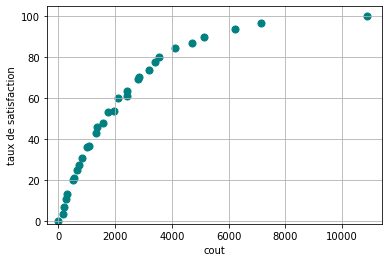

In [ ]:
import random
import json
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import numpy as np

w_list = [0]
N_pt = 31
alpha_list = np.linspace(0 , 1 , N_pt)

plt.figure()

for w in w_list :
    for alpha in alpha_list :


        # import the data

        dataFile = open('data/data2.json')  
        data = json.load(dataFile)
        accesses = data['Accesses']
        obsRequests = data['ObservationRequests'];
        nObsRequests = len(obsRequests)
        satPasses = data['Passes'];

        ######################################################
        ##################### ETAPE 4 ########################
        ######################################################


        # A simple DOCPLEX solution


        satisfied = [False for i in range(nObsRequests)]
        nObsRequestsToCover = nObsRequests
        nPasses = len(satPasses)
        remainingSatPassesIds = list(range(nPasses))
        random.shuffle(remainingSatPassesIds)
        selectedPassIds = []
        fixedPassCost = data['fixedPassCost']
        passCostPerTimeUnit = data['passCostPerTimeUnit']
        passes = data['Passes']
        obsRequests = data['ObservationRequests']
        accesses = data['Accesses']
        nAccesses = len(accesses)
        sum_priority = 0
        for i in range(nObsRequests) :
            sum_priority += (1/obsRequests[i]['priority'])**w
            #sum_priority += 1




        model = Model(name='E3-requests')

        model.parameters.timelimit = 20

        x = model.binary_var_list(range(nObsRequests), name='satisfied_requests')
        p = model.binary_var_list(range(nPasses), name='selected_passes')

        date_start = model.continuous_var_list(range(nPasses) , name='starting_date')
        date_end = model.continuous_var_list(range(nPasses) , name='ending_date')

        acces_couvert = model.binary_var_list(range(nAccesses) , name='acces_couvert')

            # Contrainte pour avoir au moins un acces de couvert.

        for i in range(nObsRequests) :
            accessIds = obsRequests[i]['accessIds'] # tous les accessIds presents dans la request i
            model.add_constraint( model.sum(acces_couvert[id] for id in accessIds) >= x[i] )


        for i in range(nAccesses) :
            pass_id = accesses[i]['passId']
            start = passes[pass_id]['start']

            end = passes[pass_id]['end']
            M = end - accesses[i]['end'] + 30
            model.add_constraint(- accesses[i]['end'] + date_start[pass_id] + 30 <= M * (1-acces_couvert[i])) 

            MM = accesses[i]['start'] - start + 30
            model.add_constraint(-date_end[pass_id] + accesses[i]['start'] + 30 <= MM * (1-acces_couvert[i]))


        for i in range(nPasses) :
            start = passes[i]['start']
            end = passes[i]['end']
            MMM = 30 
            model.add_constraint(date_end[i] - date_start[i] >= 30 * p[i])


        for i in range(nAccesses) :
            pass_id = accesses[i]['passId']
            model.add_constraint(p[pass_id] >= acces_couvert[i])


        model.add_constraint(model.sum(x[i]*((1/obsRequests[i]['priority'])**w) for i in range(nObsRequests))/sum_priority >= alpha)
        
        #model.add_constraint(model.sum(x[i] for i in range(nObsRequests))/sum_priority >= alpha)



        model.minimize( model.sum( ( p[i]*fixedPassCost + passCostPerTimeUnit*(date_end[i] - date_start[i])) for i in range(nPasses)))

        # Résolution du problème
        solution = model.solve(log_output=False)


        if solution is None:
            print("NO solution")
        else: 
            print("Le cout est de " , model.objective_value)
            print("Les passes séléctionnés sont :" , selectedPassIds)



            st = []
            ed = []
            # Affichage de la solution
            for i in range(nPasses) :
                if p[i].solution_value == 1  :
                    selectedPassIds.append(i)
                    st.append(date_start[i].solution_value)
                    ed.append(date_end[i].solution_value)
                else : 
                    st.append(0)
                    ed.append(0)

            # export the solution to json
            bookings = []
            for i in selectedPassIds:
                satPass = satPasses[i]
                bookings.append({"passId": i, "passStart": satPass['start'], "passEnd": satPass['end'], "bookingStart": st[i], "bookingEnd": ed[i]})
            jsonString = json.dumps({"Bookings": bookings})
            jsonFile = open("mySolution.json", "w")
            jsonFile.write(jsonString)
            jsonFile.close()


            # import the solution
            solutionFile = open('mySolution.json')  
            solution = json.load(solutionFile)
            c = cout(data , solution)
            s = satisfaction(data,solution)
            print(f"Le coût de la solution est {c}")
            print(f"Le taux de satisfaction de la solution est {s}\n")

            if w == w_list[0] :
                plt.scatter(c,s,marker='o',c='teal',s=50)
            else :
                plt.scatter(c,s,marker='o',c='red',s=50)

plt.grid()
plt.xlabel("cout")
plt.ylabel("taux de satisfaction")
plt.show()

In [23]:
# import the solution
solutionFile = open('mySolution.json')  
solution = json.load(solutionFile)
c = cout(data , solution)
s = satisfaction(data,solution)
print(f"Le coût de la solution est {c}")
print(f"Le taux de satisfaction de la solution est {s}")

nObsRequestsCovered = 224
nObsRequests = 225
Le coût de la solution est 1077.9999999999945
Le taux de satisfaction de la solution est 99.55555555555556
